In [2]:
import sys
print("python version: ", sys.version)

import pandas as pd
print("pandas version: ", pd.__version__)

import numpy as np
print('numpy version: ', np.__version__)

import scipy as sp
print('scipy version: ', sp.__version__)

import sklearn as skl
print('sklearn version: ', skl.__version__)

import matplotlib.pyplot as plt

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import keras as ks
print('keras version: ', ks.__version__)
print('keras backend: ', ks.backend.backend())

import tensorflow as tf
print('tensorflow version: ', tf.__version__)

import warnings
warnings.filterwarnings('ignore')

from keras import backend as K
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_recall_curve

import random

python version:  3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
pandas version:  0.24.2
numpy version:  1.16.4
scipy version:  1.3.0
sklearn version:  0.21.2


Using TensorFlow backend.


keras version:  2.2.4
keras backend:  tensorflow
tensorflow version:  1.14.0


In [3]:
excel_file = r'/home/kravchen/Desktop/NH/full_set.xlsx'
df = pd.DataFrame(pd.read_excel(excel_file))

In [4]:
print(df.shape)

(13142, 208)


In [5]:
# Drop features
f_drop = ["Blank-1", "ws-sudden-stop", "ws-sudden-stop-drugs", "ws-prolonged-psychotropics", "mds-toilet-prgm-atmptd"] + \
         ['Deleted-%d' % i for i in range(1, 13)] + ['Psychotropic-%d' % i for i in range(1, 6)] + \
         ['Psychotropic-%d-average-daily-dose' % i for i in range(1, 6)] + ["Entry-discharge-type"]

f_drop += ["acute_mental_change", "aphasia", "balance_toileting", "balance_turning_around", "bipolar", "bph", \
           "cam_motor_retardation", "cerebralpalsy", "cirrhosis", "cms-long-stay", "comatose", "conduct_pain_assmnt",\
           "dysrhythmias", "embolisms", "facility", "hemiplegia/hemiparesis", "hepatitis", "huntingtons", "hyperkalemia",\
           "hypertension", "hyperthyroidism", "hyponatremia", "hypotension", "hypothyroidism", \
           "limb_prosthesis_past_7_days", "marital-status", "mds-conduct-staff-assessment-mental-status", \
           "mds-dehydrated", "mds-delirium-scale", "mds-excess-weight-loss", "mds-long-term-memory-ok", \
           "mds-pressure-ulcer-stage-1", "mds-pressure-ulcer-stage-2", "mds-pressure-ulcer-stage-3", \
           "mds-pressure-ulcer-stage-4", "mds-short-term-memory-ok", "mds-staff-assess-pain", "multiple-sclerosis", \
           "neurogenic-bladder", "obstructive-uropathy", "paraplegia", "pneumonia", "ptsd", "pvd", "quadriplegia", \
           "renal-failure", "schizophrenia", "septicemia", "stroke", "tourettes", "traumatic-brain-injury", \
           "tuberculosis", "wound", "ws-antibiotic-anticoag-coexposure", "ws-diuretic-adl", \
           "ws-meclizine-psych-coexposure", "ws-meclizine-psych-coexposure", "ws-meclizine-psych-coexposure",\
           "ws-meclizine-psych-coexposure", "ws-meclizine-psych-coexposure", \
           "ws-psychotropic-with-not-ordered-weight-loss", "ws-tramadol-antidepressant-coexposure"]
 
# Missing value means not relevant
f_one_hot = ["Mds-fall-2-6-months-to-admission", "Mds-fall-last-month-to-admission", "mds-pain-last-five-days", \
             "recent-start-other-fall-risk-rx"]
cate_one_hot = [['Yes', 'No', 'Unable to answer']] * 3 + [['Yes', 'No']]

f_period = [("Psychotropic-%d-Start-date" % i, 'Psychotropic-%d-End-date' % i, 'Psychotropic-%d-Period' % i) for i in range(1, 6)]

f_label = ['mds-cognitive-scale', 'mds-pain-freq-last-five-days', 'mds-pain-intensity']
dic_label = [{'Independent': 0, 'Modified Independence': 1, 'Moderately Impaired': 2, 'Severely Impaired': 3}, \
             {'Continuous': 4, 'Frequent': 3, 'Occasional': 2, 'Rare': 1, 'Unable to respond': 0}, \
             {'None': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Very severe, horrible': 4}]

f_transform = [('mds-cognitive-scale', 3, 0), ('mds-pain-freq-last-five-days', 4, 0), ('mds-pain-intensity', 4, 0)] + \
              [('Psychotropic-%d-Period' % i, 0, 0) for i in range(1, 6)]

In [6]:
# Encode features (originally) with no missing values
f_drop += ["predictor-date", "projected-date", "PPS-assessment", "Federal-assessment"]

f_period += [('episode-start-date', 'episode-end-date', 'episode-period'),\
             ('stay-start-date', 'stay-end-date', 'stay-period')]

f_label += ["mds-stay-trans-short-to-long", "mds-antianxiety-medication", \
            "mds-antidepressant-medication", "mds-antipsychotic-medication", "mds-antibiotic-medication",
            "mds-anticoagulant-medication", "mds-diuretic-medication", \
            "mds-hypnotic-medication", "mds-behavioral-symptoms", "mds-behavioral-symptoms-to-others", \
            "mds-depression", "mds-fever", "mds-impaired-mobility", "mds-impaired-transfer", \
            "mds-internal-bleeding", "mds-malnutrition", "mds-no-problem-conditions", "mds-vomiting", \
            "mds-impaired-walk-in-room", "mds-impaired-walk-in-corridor", "mds-impaired-locomot-unit", \
            "mds-impaired-locomot-other"] + ["mds-pain-non-verbal"]
dic_label += [{'Yes': 1, 'No': 0}] * 22 + [{'None/Mild':0,'Moderate/Severe':1}]

f_one_hot += ["race", "gender", "mds-bims-summary-ranking"]
cate_one_hot += [['White', 'Black', 'Other'], \
                 ['Female', 'Male'], ['Intact or Moderately Intact', 'Moderate Impairment']]

In [7]:
# Features need imputation
f_one_hot += ["uti", "mdro", "anemia", "constipation", "alzheimers", "anxiety", "depression", "non-alz-dimentia", \
              "parkinsons", "psychosis", "seizure", "emphysema", "arthritis", "ashd", "cancer", "diabetes", "gerd",\
              "heart-failure", "osteoporosis", "thyroid-disorder", "transient-ischemic-attack", "mds-pain-medication", \
              "mds-received-pain-tx-non-pharm", "mds-received-prn-pain-medication", "mds-pressure-ulcer-prsnt", \
              "conduct_bims", "cane_or_crutch_past_7_days", "walker_past_7_days", "wheelchair_past_7_days", \
              "no_listed_mobility_device", "hyperlipidemia"] + \
              ["balance_while_standing", "balance_while_walking", "balance_bed_to_chair"] + ["mds-entered-from"]
cate_one_hot += [['Yes', 'No']] * 31 + \
                [["Steady at all times", "able to stabilize without assistance", \
                  "able to stabilize with assistance", "Activity did not occur"]] * 3 + \
                [["Acute Hospital", "Psychiatric Hospital", "Another nursing home or swing bed", "Hospice", \
                  "Inpatient rehabilitation facility",
                  "Community (private home/apt., board/care, assisted living, group home)", "Other"]]

f_label += ["mds-urinary-incontinence", "functlimit_rom_upper", "functlimit_rom_lower", "does_resident_wander"] + \
           ["cam_inattention", "cam_disorganized_thought", "cam_altered_conc"]
dic_label += [{"Always continent": 0, "Occasionally incontinent": 1, "Frequently incontinent": 2,\
               "Always incontinent": 3, "Catheter - not rated": np.nan}] + \
             [{"No impairment": 0, "Impairment on one side": 1, "Impairment on both sides": 2}] * 2 + \
             [{"Behavior not exhibited": 0, "1 to 3 days": 1, "4 to 6 days": 2, "occurred daily": 3}] + \
             [{"Behavior not present": 0, "Behavior present, fluctuates": 1, "Behavior continuously present": 2}] * 3

f_transform += [("mds-urinary-incontinence", 3, 0), ("cam_inattention", 2, 0), ("cam_disorganized_thought", 2, 0), \
                ("cam_altered_conc", 2, 0), ("functlimit_rom_upper", 2, 0), \
                ("functlimit_rom_lower", 2, 0), ("does_resident_wander", 3, 0)]

In [8]:
# Set sdd=0 to NA
for i in range(1, 6):
    df.loc[df['psych_sdd_%d' % i] == 0, 'psych_sdd_%d' % i] = np.nan
# These data were dropped in Experiment 1
f_transform += [('psych_sdd_%d' % i, 0, 0) for i in range(1, 6)]

In [9]:
# Dropping min effective dose and one hot encoding ATC psychotropic drugs
# These data were not used in Experiment 1 b/c of missing values
f_drop += ["min_effective_dose_%d" % i for i in range(1, 6)]

atc_list = []
for i in range(1, 6):
    atc_list.append(df.groupby('atc_%d' % i)['min_effective_dose_%d' % i].first())
atc_codes = pd.concat(atc_list)
atc_codes = atc_codes[~atc_codes.index.duplicated()].index.tolist()
f_one_hot += ["atc_%d" % i for i in range(1, 6)]
cate_one_hot += [atc_codes] * 5

In [10]:
df['patient-id'] = df['patient-id'].astype('str')

In [11]:
list_pid = ['01c9bd28cd38934a6b6598c2f0c595e2','022c3df43beb87426fdc9e3aece863ed','028fedbb573c6bfa76fbde3cfef2aeee',
            '03af5cb05c302b9a8c2ccae1c91da4d0','0461c03862af4e50ce159a73f004b001','050e80396569549c813bd86878395edd',
            '059e7c93e64ac77e36a2e5837e48be77','05f01f0d1a7272b250d63cb579b1daf2','066a29d308fa4d898102a3e9f647de6f',
            '066ce145d5b174af066254e5be1585e2','0912055f2195755d7bef28609d049dd0','0f79f492f4c8473c31201ccd41f102b8',
            '125560598c5696e07f71c3f4da381d2f','135ceeb77bd08c60a947f74b9fd83d00','159cf0cc2acd9e91a05a523c7a152329',
            '16f552deb3c2ba571d073738cb554126','19632eeb65376617bd612503132285e2','1d46d1f923cfa7e3a7b23a737637981b',
            '1e15c99576756e3a1823a5f6aedd7f18','1fa6c165ef356f3252f06e7ca18c50fe','2085480e932df230b019761f6174200a',
            '2113f02d0df3a6963ff61e16bc4ad767','243bca59454a35fd31a80856898f4f08','28be643baa0fb455c9c311646f0041b8',
            '2a6db0f42c1d5d1c4f1342c5291b6c01','2b57427d702a8c4e375cd02fdd0cf387','2b6732124cae3953adecd89836537beb',
            '2d71fe90931c6e12ef800c4cba5377e3','3157f5db65d2f725c739a7ef98ec8b4e','32ac39841c469a47d86eb43abf35f3d5',
            '33eccc93bc55ba7619a6d1e333baf1f5','343df02f2dfc3c1ad6428e7e1c246585','37f069da79c11e4e9c01794b38bfa39f',
            '394f22d67bf57e6bfeebcf21242b38a5','3cff678dc116ea0c96bbc918057bc7c5','3d3fddbdfd3583a6d9d2c8e7f30c3cfb',
            '3d73b4edb7027ac1a8afd46ecc91e010','3df5c258d2032361615b2f9855bf554f','3e1f2a5ed144a2564c9857a530d25435',
            '4125a264d97877a301892fdd0f40431e','419328961cb5cf6fbaeb4178d2b77e46','4272f93c23b65e2c2a76a1daf8d40c43',
            '4b3fb60a20ef687a3f7c7d298467ee98','4cb9543864cb8cbe3e4bd66b0928b3f3','4cf06d285a6c3ca4591603c22536e2f0',
            '4d0739e22fc57d8cee62ad1d07ae1dd8','4e9a52901f6c1c38f0651378a4b60c61','50c824b1d52dc56df894d991f2ec46a8',
            '528ba7513e8a789dbb47ef90ccd861ac','58cc1f6d463a9034a9cf51c1f7e50804','5914c3856eba88d19500ce0cafd35ef1',
            '59545dcc4048310c4b8f09269ac7ce07','5a5aaba2d783818513a3cf640a18720a','5e3e1d07b47dac2ced35258ae59ff686',
            '602dd3b3ef35189913b236748df90361','606aa687675a9ea23d9b9a7329e1ca89','61422cfa73ea89c6d0b0268b6c89e492',
            '617487bcc3dc2194fd094ea86e0e49e9','6219b2510e1b28eb0a7f48c3f7fdb52c','63f1056a29e7b12278e41d0f13f59de6',
            '64badf6afcc2b2e7b2288c17d74af035','65d7aa76dc841c84dfa376ed2bff6d65','6879012f2cf2f93673a2793ccf09c616',
            '69439f6799adc0ecebe5d8062ce0db5b','6b037a194ef4976eeb4803b62c4fb719','7040cd5b48783e42bf69ad8ae1130db5',
            '73a5736925da1fdb859ab54bfdedbfff','7419e251e895417a3a3ad7e47f688b29','774354380b368224856c600805762b03',
            '778606017ea378b29c4235662dd77a9b','781c7032ce133dd852b96ccd2d11e4bf','7f7464781c2b59b1979ed129ba5866ef',
            '8255666eee1ff0e1738dbd63d47ab6aa','83fd66c1795678c3116e9398298fe73a','84ee1eaf7070d3a9c2bca4e4bc041bf2',
            '87bc682f79ea761ddbdbb013050a1c5b','87c81ea150ff908dde537131cd2b8678','890b8e1488a926c3d61ca5cdf269c042',
            '898b48ced3f1e9dd37295d534c53a39d','8bb9b6b57afd916d9cbd154b58aee93a','8f497041c5cc920c1189c006b02be284',
            '8fe7afaf70fc15b77f5a4a45076db512','91042073096161389f78bcf12b373ac8','922c7f6d9b7ada7bf349b9ca9e0690c8',
            '927974d7535434e1dcf3c7cfba4b9493','94b51da11d9030efe8f0ae2a258b5249','958fcb3de326daceb8bca6f71c7f5f31',
            '974cabadc622c98bacb02e0c11cca489','97d6876c1ab25f3b1b157afea04ce085','991e202dbf8f3fa69c5bea40e4e22d32',
            '9ba083b4aeef838bb60273a1d85c51e8','9c83331eaf085e5226215fa8b0183264','a19c4a24fd629208c04e8da5226c18ec',
            'a2f272d11c96df42d2163777bc8b9530','a7bc2122f362b14549d93cc3f888211c','a91c38bf9a58e1f03b7d88d952183175',
            'ab2bc61274221eb593838366c4046d4e','b70b10fecd0dc4459b5f79fe1c27a066','ba04153243cd16383154dd03c3ab3d3d',
            'bb95450097bf3c9225491ab15f23bcbe','bbc54ea74865d7a669648770bec1a8ed','bbf942add1eb11d25de4bcd587255e8d',
            'bcd63981899e769ab4986af9cf68ecbc','bde50fe656168818a77249c148a49889','bdef2cfe5abcfbd00ec4e89bbdecdb4c',
            'be39412453a33d32d0cbc6fa2212e28f','bfcd1ac21134401a12e49a4d6be167a3','bfea8bd973b40144d41ecb96a463991a',
            'bff2ebb09d73c89167241250440c475e','c0adcc870ca075369537f7cd0877576a','c43e268913b76a1459b065476b86e2ff',
            'c45f458bc9561029985c973235627185','c4ba9f5f0b6ae3cfedc6bbc8a3b2c2a0','c4d2a7f360cd8f7b22cd7cf748b83ec7',
            'c8cec1bb3ccdb5e85d4a2068d81055b0','c9c7312b0816720c953a449dc3007635','cab79650794648699c676a3d19cdb009',
            'cb0166129d1c010d264776aef3b55510','ccc01717be747dd7d59a19ee79544b0a','cdb953820470775894008c4cb16c2c17',
            'd16aaa7f5eca772d64e756821630ec7f','d27c1300551cd5163d6f895adbba91cd','d42790b38a297d4f424f5c6503d99d62',
            'd5d7628be40c7cf6ebe8246a46f8038a','d7edbb8d7813c32bb838a90e7c485b2b','da853215664367774c410210e67d1028',
            'de9c1b2cf691af973ae00cc2d8e3ec15','e1ff6970a403794a37514b93e34a111f','e2283dc2db45396b4c6cce396168a8bf',
            'e2c6a76355fa923cd66d93359c3bd938','e38e043f8c26f5c4a6ec970bda188474','e414586b30c0b6d57a34ea69e0c30c0e',
            'e647db52770cc1af0cb377543b4eb303','e7567ff5caecf54f0ff222be914725dc','ea7455ba2d24883ea75b5b8213bb5569',
            'eb1c1a8c716fb70f25f745ebbc3b3b8f','eb1f2d920e97bb91ad6c9fdb809838fa','ef70587998eb7bc12c6466c36590a539',
            'effff673ae3df86f25970195d9fcf269','f5859bf3807ff3daa51967cce30a8d17','f967b6504968aaee43c2c6ac6ec3234a',
            'fc636cef2e6ea2fe9d9db02eeb673d11'] 

In [12]:
df1 = df[~df['patient-id'].isin(list_pid)]

In [13]:
# generate target
target = df1['outcome-Mds-fall-since-prior-assessment'].map({'None': 0, 'Yes': 1})
dff = df1.drop(['outcome-mds-fall-no-injury', 'outcome-mds-fall-minor-injury', 'outcome-mds-fall-major-injury', \
               'outcome-Mds-fall-since-prior-assessment', 'outcome-riskmaster-fall-incident'], axis=1)

In [14]:
# train test split
from sklearn.model_selection import GroupShuffleSplit
def train_test_split(df, target, groupby, radio, random_state):
    train_idx, test_idx = next(GroupShuffleSplit(train_size=radio, test_size=1-radio, random_state=random_state).split(df, target, df[groupby]))
    return df.iloc[train_idx], df.iloc[test_idx], target.iloc[train_idx], target.iloc[test_idx]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(dff, target, 'patient-id', 0.7, 0)
print('Total number of patients: %d' % len(df.groupby('patient-id')))
print('Number of patients in training set: %d' % len(X_train.groupby('patient-id')))

Total number of patients: 4903
Number of patients in training set: 3332


In [16]:
# drop feature
def drop_features(df, f):
    df.drop(f, axis=1, inplace=True)
    
# one hot encoding
def one_hot_encoding(df, features, categories):
    for f, c in zip(features, categories):
        df[f] = df[f].astype('category', categories=c)
    return pd.get_dummies(df, columns=features, prefix=features)

# compute date difference
def date_diff(start, end):
    return (pd.to_datetime(end) - pd.to_datetime(start)) / np.timedelta64(1, 'D')

# generate date diff features
def generate_period(df, f):
    for start, end, period in f:
        df[period] = date_diff(df[start], df[end])
        df.drop([start, end], axis=1, inplace=True)
        
# label encoding
def label_encoding(df, features, dictionaries):
    for f, dic in zip(features, dictionaries):
        df[f] = df[f].map(dic)
        
# sin&cos transform
def col_transform(df, col, mmax, mmin, df_ref=None):
    if(mmax <= mmin):
        # for test set, if max&min not set, use training set value
        if(df_ref is not None): 
            mmax = df_ref[col].max()
#            mmin = df_ref[col].max()
            mmin = df_ref[col].min()
 
        else:
            mmax = df[col].max()
            mmin = df[col].min()
    angle = 0.25 * np.pi * (df[col] - mmin) / (mmax - mmin) + 0.125 * np.pi
    return (np.cos(angle), np.sin(angle))

def df_transform(df, f, df_ref=None):
    for col, mmax, mmin in f:
        df[col + '_x'], df[col + '_y'] = col_transform(df, col, mmax, mmin, df_ref)
        df[col + '_x'].fillna(0, inplace=True)
        df[col + '_y'].fillna(0, inplace=True)
        df.drop(col, axis=1, inplace=True)

In [17]:
%%time
## Training set data reshaping
generate_period(X_train, f_period)
label_encoding(X_train, f_label, dic_label)
X_train_original = X_train.copy() # store value range
df_transform(X_train, f_transform)
X_train = one_hot_encoding(X_train, f_one_hot, cate_one_hot)
drop_features(X_train, f_drop)

CPU times: user 1min 36s, sys: 1.68 s, total: 1min 38s
Wall time: 24.3 s


In [18]:
X_train_use = X_train.copy()

In [19]:
print(X_train.dtypes[X_train.dtypes == 'object'].index)

Index(['patient-id'], dtype='object')


In [20]:
# missing data describe
def missing_summary(df):
    missing_cnt = df.isna().sum()
    missing_data = pd.concat([missing_cnt, missing_cnt/df.shape[0]], axis=1, keys=['count', 'percentage'])
    return missing_data[missing_data['percentage'] != 0].sort_values(by='percentage', ascending=False)

missing_summary(X_train_use)

,count,percentage


In [21]:
X_train_use = X_train_use.dropna(subset=['mds-adl-scale'])

In [22]:
a = X_train_use.isna().sum()
a['mds-adl-scale']

0

In [23]:
len(list_pid)

142

In [24]:
#drop rows with missing mds-adl-scale data
#X_train_use = X_train_use[X_train_use.mds-adl-scale. != 'NaN']
#X_train_use = X_train_use['mds-adl-scale'] != 'NaN'

In [25]:
%%time
## Test set data reshaping
generate_period(X_test, f_period)
label_encoding(X_test, f_label, dic_label)
df_transform(X_test, f_transform, X_train_original)
X_test = one_hot_encoding(X_test, f_one_hot, cate_one_hot)
drop_features(X_test, f_drop)

CPU times: user 21 s, sys: 55.7 ms, total: 21.1 s
Wall time: 21.1 s


In [26]:
X_test_use = X_test.copy()

In [27]:
X_test_use = X_test_use.dropna(subset=['mds-adl-scale'])

In [28]:
X_train_use.shape

(8600, 398)

In [29]:
X_test_use.shape

(3692, 398)

In [30]:
X_train_use.head()

,patient-id,current-stay-days,cumulative-days-in-facility,mds-stay-trans-short-to-long,age,mds-antianxiety-medication,mds-antidepressant-medication,mds-antipsychotic-medication,mds-antibiotic-medication,mds-anticoagulant-medication,...,atc_5_N06AB10,atc_5_N06AX05,atc_5_N06AX11,atc_5_N06AX12,atc_5_N06AX16,atc_5_N06AX21,atc_5_N06AX24,atc_5_N05AA01,atc_5_N05BA05,atc_5_N06AX23
0,10353,7,7,0,67,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10364,7,7,1,84,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,10379,7,7,0,84,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,5000,7,7,0,90,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,5003,7,7,1,90,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
X_test_use.head()

,patient-id,current-stay-days,cumulative-days-in-facility,mds-stay-trans-short-to-long,age,mds-antianxiety-medication,mds-antidepressant-medication,mds-antipsychotic-medication,mds-antibiotic-medication,mds-anticoagulant-medication,...,atc_5_N06AB10,atc_5_N06AX05,atc_5_N06AX11,atc_5_N06AX12,atc_5_N06AX16,atc_5_N06AX21,atc_5_N06AX24,atc_5_N05AA01,atc_5_N05BA05,atc_5_N06AX23
3,10385,7,7,1,85,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,10386,7,7,1,77,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11,5030,7,7,0,82,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,5030,28,84,0,82,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,5030,42,164,0,82,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# The main difference in this experiment from experiment 2 is that it  
# includes clincally important variables (based on domain knowledge), 
# imputing them if neede, and drops a bunch of likely non-relevant features 
# (TODO:recall if this is based on feature selection + expert knowledge?)
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, Masking, TimeDistributed
from numpy.random import seed
from tensorflow import set_random_seed
from copy import deepcopy
from keras.preprocessing.sequence import pad_sequences

In [33]:
def scaler_transform(X_train_use, X_test_use):    
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X_train_use.drop('patient-id', axis=1))
    X_train_transformed = pd.DataFrame(scaler.transform(X_train_use.drop('patient-id', axis=1)), \
                                       columns=X_train_use.columns[1:], index=X_train_use.index)                                   
    X_train_transformed['patient-id'] = X_train_use['patient-id']
    X_test_transformed = pd.DataFrame(scaler.transform(X_test_use.drop('patient-id', axis=1)), \
                                       columns=X_test_use.columns[1:], index=X_test_use.index) 
    X_test_transformed['patient-id'] = X_test_use['patient-id']
    return X_train_transformed, X_test_transformed

In [34]:
def add_previous_outcome(X, Y):
    X = X.copy()
    x1, x2 = [], []
    pids = X['patient-id'].unique()
    for pid in pids:
        df = Y[X[X['patient-id']==pid].index]
        if(df.shape[0] == 1):
            x1.append(pd.Series([0]))
            x2.append(pd.Series([0]))
        else:
            # input 1=(1, 0), 0=(0, 1), NA=(0, 0)
            x1.append(pd.Series([0]))
            x1.append(df[:-1])
            x2.append(pd.Series([0]))
            x2.append(df[:-1].map({0: 1, 1: 0}))
    X['input_outcome_x'] = pd.Series(pd.concat(x1, ignore_index=True).tolist(), index=X.index)
    X['input_outcome_y'] = pd.Series(pd.concat(x2, ignore_index=True).tolist(), index=X.index)
    return X

In [35]:
## This step converts the outcome to a point in x,y coordinates where fall (1) = (1,0); no fall (0) = (0,1); and NA = (0,0) 
X_train_use = add_previous_outcome(X_train_use, y_train)
X_test_use = add_previous_outcome(X_test_use, y_test)

## This step transforms the data to range between 0 and 1
X_train_transformed, X_test_transformed = scaler_transform(X_train_use, X_test_use)

In [36]:
def generate_nested_list(X, Y):
    x_list, y_list = [], [] 
    pids = X['patient-id'].unique()
    for pid in pids:
        df = X[X['patient-id']==pid]
        y_list.append(Y[df.index].values)
        x_list.append([record for record in df.drop('patient-id', axis=1).values])
    return x_list, y_list

def mygenerator(x_list, y_list=None):
    if(y_list is not None):
        while True:
            for x, y in zip(x_list, y_list):
                yield np.array(x).reshape((len(x), 1, x[0].shape[0])), y
    else:
        while True:
            for x in x_list:
                yield np.array(x).reshape((len(x), 1, x[0].shape[0])) 
                
def fit_model(model, epoch, X_train, y_train, X_valid=None, y_valid=None, verbose=0):
    history = model.fit(X_train, y_train, epochs=epoch, verbose=verbose)
    if(verbose != 0):
        plot_history(history)
    return history

def plot_roc_curve(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
def plot_history(history, loss=None, val_loss=None):
    if(history is not None):
        loss = history.history['loss']
    plt.figure()
    plt.plot(loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if('val_loss' in history.history):
        val_loss = history.history['val_loss']
        plt.plot(val_loss)
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [37]:
def pad_data(X, maxlen):
    return pad_sequences(X, maxlen=maxlen, dtype='float64', padding='post')

def pad_all(X_train, y_train, X_test, y_test, maxlen):
    return pad_data(X_train, maxlen), pad_data(y_train, maxlen), pad_data(X_test, maxlen), pad_data(y_test, maxlen)

In [38]:
def auroc(y_predict, y_true, plot=False):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1)    
    if(plot):
        plot_roc_curve(fpr, tpr)
    return auc(fpr, tpr)


def find_best_f1(y_predict, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1) 
    max_f1, th = 0, 0
    for threshold in thresholds:
        f1 = f1_score(y_true, y_predict > threshold)
        if(f1 > max_f1):
            max_f1 = f1
            th = threshold
    return max_f1, th

def other_metrics(y_predict, y_true, threshold):
    y_threshold = y_predict > threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_threshold).ravel()
    return precision_score(y_true, y_threshold), recall_score(y_true, y_threshold),\
            accuracy_score(y_true, y_threshold), float(tn) / (tn + fp)

In [39]:
from sklearn.model_selection import GroupKFold
def kfold_validation(unit, ratio, epoch, X, y, groupby, n_features, k=5, verbose=0, max_timestamps=20):
    auroc_list = []
    other_metric_list = []
    for train_idx, valid_idx in GroupKFold(n_splits=5).split(X, y, X[groupby]):
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
        X_train, y_train = generate_nested_list(X_train, y_train)
        X_valid, y_valid = generate_nested_list(X_valid, y_valid)
        X_train_pad, y_train_pad, X_valid_pad, y_valid_pad = pad_all(X_train, y_train, X_valid, y_valid, max_timestamps)
        y_train_pad = y_train_pad.reshape(y_train_pad.shape[0], y_train_pad.shape[1], 1)
        seed(1)
        set_random_seed(2)
        model = build_model(unit, ratio, max_timestamps, n_features)
        fit_model(model, epoch, X_train_pad, y_train_pad, verbose=verbose)
        y_valid_len = [len(y) for y in y_valid]
        y_predict = model.predict(X_valid_pad)
        y_predict = truncate_prediction(y_predict, y_valid_len)
        y_true = np.concatenate(y_valid)
        auroc_list.append(auroc(y_predict, y_true))
        f1, th = find_best_f1(y_predict, y_true)
        precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
        other_metric_list.append((precision, recall, accuracy, specificity,f1,th))
    return (auroc_list, other_metric_list)

In [40]:
# shape: (num_of_patients, num_of_records, num_of_features)
X_train_list, y_train_list = generate_nested_list(X_train_transformed, y_train)
X_test_list, y_test_list = generate_nested_list(X_test_transformed, y_test)

In [41]:
## comparing this to the experiment 1 transformed dataset to confirm that this has 
## diagnoses and ATC codes while the other does not
X_train_transformed.to_csv (r'/tmp/exp3_RNN_train_transformed_df.csv', index = False, header=True)

In [42]:
X_train_transformed.shape

(8600, 400)

In [43]:
#X_train_transformed.isnull().any()

In [44]:
X_test_transformed.shape

(3692, 400)

In [45]:
#X_test_transformed

In [46]:
max_timestamps = df.groupby(['patient-id']).size().max()
print(max_timestamps)

20


In [47]:
n_features = X_train_list[0][0].shape[0]
print(n_features)

399


In [48]:
## function to build a SimpleRNN
from keras import regularizers
from keras.optimizers import Adagrad, Adadelta
def build_model(units, dropout_ratio, n_timesteps, n_dimensions):
    model = Sequential()
    model.add(Masking(input_shape=(n_timesteps, n_dimensions)))
    model.add(SimpleRNN(units, return_sequences=True, recurrent_dropout=dropout_ratio, dropout=0.5))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))
    model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['binary_accuracy'])
    return model

In [49]:
def truncate_prediction(y_, y_len):
    y_concat = []
    for i, y in enumerate(y_):
        y_concat.append(np.concatenate(y[:y_len[i], :]))
    y_concat = np.concatenate(y_concat)
    return y_concat

In [50]:
## the data is padded so that the final shape is as follows with the outcome data array having the same
## shape but only one value
#  array([[patient 1 data record 1],  
#         [patient 1 data record 2],
#         ...
#         [patient 1 data record 19],
#        ],
#        [[patient 2 data record 1],  
#         [patient 2 data record 2],
#         ...
#         [patient 2 data record 19],
#        ],
#        ...
#       )
# 
X_train_pad, y_train_pad, X_test_pad, y_test_pad = pad_all(X_train_list, y_train_list, X_test_list, y_test_list, max_timestamps)
#y_train_pad = y_train_pad.reshape((2193, 19, 1))

In [51]:
y_train_pad.shape

(3332, 20)

In [52]:
y_train_pad = y_train_pad.reshape((3332, 20, 1))

In [53]:
np.isnan(X_test_pad).any()
#np.where(np.isnan(X_test_pad))

False

In [54]:
#np.savetxt(r'~/Desktop/NH/X_train_pad.txt', X_train_pad.values)
np.savetxt("X_train_pad.txt", X_train_pad[i], delimiter = ',')
#with open("X_train_pad.txt", "w+") as f:
#    data = f.read()
#    f.write(str(X_train_pad))


W0609 23:36:15.061068 140537491949376 deprecation_wrapper.py:119] From /usr/local/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0609 23:36:15.063187 140537491949376 deprecation_wrapper.py:119] From /usr/local/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0609 23:36:15.095891 140537491949376 deprecation_wrapper.py:119] From /usr/local/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0609 23:36:15.416158 140537491949376 deprecation_wrapper.py:119] From /usr/local/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_

Epoch 1/225
3332/3332 [==============================] - 3s 984us/step - loss: 0.4365 - binary_accuracy: 0.8364
Epoch 2/225
3332/3332 [==============================] - 1s 412us/step - loss: 0.4084 - binary_accuracy: 0.8426
Epoch 3/225
3332/3332 [==============================] - 1s 422us/step - loss: 0.4099 - binary_accuracy: 0.8409
Epoch 4/225
3332/3332 [==============================] - 1s 426us/step - loss: 0.4064 - binary_accuracy: 0.8418
Epoch 5/225
3332/3332 [==============================] - 1s 404us/step - loss: 0.4003 - binary_accuracy: 0.8427
Epoch 6/225
3332/3332 [==============================] - 1s 403us/step - loss: 0.4013 - binary_accuracy: 0.8424
Epoch 7/225
3332/3332 [==============================] - 1s 439us/step - loss: 0.4049 - binary_accuracy: 0.8418
Epoch 8/225
3332/3332 [==============================] - 1s 394us/step - loss: 0.3976 - binary_accuracy: 0.8439
Epoch 9/225
3332/3332 [==============================] - 1s 407us/step - loss: 0.3962 - binary_accuracy:

3332/3332 [==============================] - 1s 433us/step - loss: 0.3891 - binary_accuracy: 0.8452
Epoch 74/225
3332/3332 [==============================] - 1s 432us/step - loss: 0.3939 - binary_accuracy: 0.8422
Epoch 75/225
3332/3332 [==============================] - 2s 453us/step - loss: 0.3892 - binary_accuracy: 0.8450
Epoch 76/225
3332/3332 [==============================] - 1s 425us/step - loss: 0.3914 - binary_accuracy: 0.8436
Epoch 77/225
3332/3332 [==============================] - 1s 402us/step - loss: 0.3889 - binary_accuracy: 0.8431
Epoch 78/225
3332/3332 [==============================] - 1s 393us/step - loss: 0.3897 - binary_accuracy: 0.8430
Epoch 79/225
3332/3332 [==============================] - 1s 387us/step - loss: 0.3893 - binary_accuracy: 0.8438
Epoch 80/225
3332/3332 [==============================] - 1s 386us/step - loss: 0.3902 - binary_accuracy: 0.8424
Epoch 81/225
3332/3332 [==============================] - 1s 388us/step - loss: 0.3860 - binary_accuracy: 0.8

3332/3332 [==============================] - 2s 461us/step - loss: 0.3847 - binary_accuracy: 0.8471
Epoch 146/225
3332/3332 [==============================] - 1s 433us/step - loss: 0.3854 - binary_accuracy: 0.8448
Epoch 147/225
3332/3332 [==============================] - 1s 412us/step - loss: 0.3897 - binary_accuracy: 0.8439
Epoch 148/225
3332/3332 [==============================] - 1s 403us/step - loss: 0.3870 - binary_accuracy: 0.8454
Epoch 149/225
3332/3332 [==============================] - 1s 416us/step - loss: 0.3863 - binary_accuracy: 0.8459
Epoch 150/225
3332/3332 [==============================] - 1s 399us/step - loss: 0.3841 - binary_accuracy: 0.8457
Epoch 151/225
3332/3332 [==============================] - 1s 397us/step - loss: 0.3888 - binary_accuracy: 0.8472
Epoch 152/225
3332/3332 [==============================] - 1s 397us/step - loss: 0.3819 - binary_accuracy: 0.8459
Epoch 153/225
3332/3332 [==============================] - 1s 402us/step - loss: 0.3856 - binary_accur

Epoch 217/225
3332/3332 [==============================] - 1s 384us/step - loss: 0.3869 - binary_accuracy: 0.8445
Epoch 218/225
3332/3332 [==============================] - 1s 386us/step - loss: 0.3761 - binary_accuracy: 0.8512
Epoch 219/225
3332/3332 [==============================] - 1s 384us/step - loss: 0.3860 - binary_accuracy: 0.8445
Epoch 220/225
3332/3332 [==============================] - 1s 383us/step - loss: 0.3798 - binary_accuracy: 0.8461
Epoch 221/225
3332/3332 [==============================] - 1s 385us/step - loss: 0.3879 - binary_accuracy: 0.8447
Epoch 222/225
3332/3332 [==============================] - 1s 383us/step - loss: 0.3896 - binary_accuracy: 0.8436
Epoch 223/225
3332/3332 [==============================] - 1s 392us/step - loss: 0.3808 - binary_accuracy: 0.8505
Epoch 224/225
3332/3332 [==============================] - 1s 388us/step - loss: 0.3868 - binary_accuracy: 0.8483
Epoch 225/225
3332/3332 [==============================] - 1s 384us/step - loss: 0.3838 

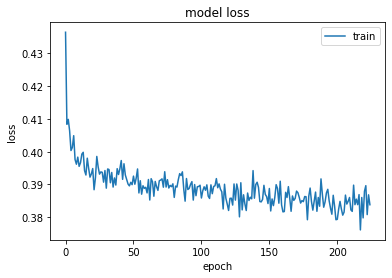

auroc:  0.7617687764003809
f1:  0.4398200224971878
threshold:  0.15934363
precision:  0.3322005097706032
recall:  0.6505823627287853
accuracy:  0.7302275189599133
specificity:  0.7457133613717244
CPU times: user 15min 27s, sys: 2min 18s, total: 17min 46s
Wall time: 5min 14s


In [55]:
%%time
### A single run w/out cross-validation
# with previous outcome added to the features
# outcome is added before scaling
seed(1)
set_random_seed(2)
model = build_model(32, 0.5, max_timestamps, n_features)
fit_model(model, 225, X_train_pad, y_train_pad, verbose=1)
y_predict = model.predict(X_test_pad)
y_test_len = [len(y) for y in y_test_list]
y_predict = truncate_prediction(y_predict, y_test_len)
y_true = np.concatenate(y_test_list)
print('auroc: ', auroc(y_predict, y_true))
f1, th = find_best_f1(y_predict, y_true)
print('f1: ', f1);
print('threshold: ', th)
precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print('specificity: ', specificity)

In [56]:
y_predict

array([0.11242312, 0.3024963 , 0.09739235, ..., 0.08413118, 0.06425738,
       0.07397228], dtype=float32)

Epoch 1/225
2666/2666 [==============================] - 2s 653us/step - loss: 0.4435 - binary_accuracy: 0.8342
Epoch 2/225
2666/2666 [==============================] - 1s 390us/step - loss: 0.4185 - binary_accuracy: 0.8395
Epoch 3/225
2666/2666 [==============================] - 1s 385us/step - loss: 0.4088 - binary_accuracy: 0.8388
Epoch 4/225
2666/2666 [==============================] - 1s 396us/step - loss: 0.4072 - binary_accuracy: 0.8419
Epoch 5/225
2666/2666 [==============================] - 1s 393us/step - loss: 0.4074 - binary_accuracy: 0.8411
Epoch 6/225
2666/2666 [==============================] - 1s 386us/step - loss: 0.4018 - binary_accuracy: 0.8408
Epoch 7/225
2666/2666 [==============================] - 1s 390us/step - loss: 0.4052 - binary_accuracy: 0.8435
Epoch 8/225
2666/2666 [==============================] - 1s 420us/step - loss: 0.4085 - binary_accuracy: 0.8404
Epoch 9/225
2666/2666 [==============================] - 1s 423us/step - loss: 0.4006 - binary_accuracy:

2666/2666 [==============================] - 1s 393us/step - loss: 0.3952 - binary_accuracy: 0.8397
Epoch 74/225
2666/2666 [==============================] - 1s 389us/step - loss: 0.3935 - binary_accuracy: 0.8440
Epoch 75/225
2666/2666 [==============================] - 1s 380us/step - loss: 0.3922 - binary_accuracy: 0.8428
Epoch 76/225
2666/2666 [==============================] - 1s 385us/step - loss: 0.3928 - binary_accuracy: 0.8411
Epoch 77/225
2666/2666 [==============================] - 1s 382us/step - loss: 0.3852 - binary_accuracy: 0.8468
Epoch 78/225
2666/2666 [==============================] - 1s 379us/step - loss: 0.3904 - binary_accuracy: 0.8427
Epoch 79/225
2666/2666 [==============================] - 1s 384us/step - loss: 0.3887 - binary_accuracy: 0.8452
Epoch 80/225
2666/2666 [==============================] - 1s 379us/step - loss: 0.3902 - binary_accuracy: 0.8418
Epoch 81/225
2666/2666 [==============================] - 1s 385us/step - loss: 0.3894 - binary_accuracy: 0.8

2666/2666 [==============================] - 1s 380us/step - loss: 0.3886 - binary_accuracy: 0.8440
Epoch 146/225
2666/2666 [==============================] - 1s 385us/step - loss: 0.3868 - binary_accuracy: 0.8444
Epoch 147/225
2666/2666 [==============================] - 1s 380us/step - loss: 0.3842 - binary_accuracy: 0.8459
Epoch 148/225
2666/2666 [==============================] - 1s 379us/step - loss: 0.3878 - binary_accuracy: 0.8427
Epoch 149/225
2666/2666 [==============================] - 1s 384us/step - loss: 0.3931 - binary_accuracy: 0.8424
Epoch 150/225
2666/2666 [==============================] - 1s 381us/step - loss: 0.3884 - binary_accuracy: 0.8422
Epoch 151/225
2666/2666 [==============================] - 1s 382us/step - loss: 0.3888 - binary_accuracy: 0.8460
Epoch 152/225
2666/2666 [==============================] - 1s 384us/step - loss: 0.3886 - binary_accuracy: 0.8442
Epoch 153/225
2666/2666 [==============================] - 1s 382us/step - loss: 0.3874 - binary_accur

Epoch 217/225
2666/2666 [==============================] - 1s 386us/step - loss: 0.3837 - binary_accuracy: 0.8462
Epoch 218/225
2666/2666 [==============================] - 1s 386us/step - loss: 0.3865 - binary_accuracy: 0.8461
Epoch 219/225
2666/2666 [==============================] - 1s 391us/step - loss: 0.3909 - binary_accuracy: 0.8422
Epoch 220/225
2666/2666 [==============================] - 1s 382us/step - loss: 0.3817 - binary_accuracy: 0.8480
Epoch 221/225
2666/2666 [==============================] - 1s 389us/step - loss: 0.3866 - binary_accuracy: 0.8447
Epoch 222/225
2666/2666 [==============================] - 1s 390us/step - loss: 0.3844 - binary_accuracy: 0.8449
Epoch 223/225
2666/2666 [==============================] - 1s 385us/step - loss: 0.3829 - binary_accuracy: 0.8454
Epoch 224/225
2666/2666 [==============================] - 1s 390us/step - loss: 0.3851 - binary_accuracy: 0.8452
Epoch 225/225
2666/2666 [==============================] - 1s 404us/step - loss: 0.3798 

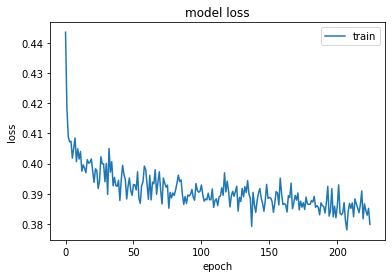

Epoch 1/225
2666/2666 [==============================] - 2s 662us/step - loss: 0.4471 - binary_accuracy: 0.8361
Epoch 2/225
2666/2666 [==============================] - 1s 396us/step - loss: 0.4195 - binary_accuracy: 0.8377
Epoch 3/225
2666/2666 [==============================] - 1s 398us/step - loss: 0.4144 - binary_accuracy: 0.8415
Epoch 4/225
2666/2666 [==============================] - 1s 395us/step - loss: 0.4072 - binary_accuracy: 0.8406
Epoch 5/225
2666/2666 [==============================] - 1s 402us/step - loss: 0.3996 - binary_accuracy: 0.8437
Epoch 6/225
2666/2666 [==============================] - 1s 392us/step - loss: 0.3970 - binary_accuracy: 0.8444
Epoch 7/225
2666/2666 [==============================] - 1s 395us/step - loss: 0.4050 - binary_accuracy: 0.8413
Epoch 8/225
2666/2666 [==============================] - 1s 395us/step - loss: 0.4011 - binary_accuracy: 0.8394
Epoch 9/225
2666/2666 [==============================] - 1s 392us/step - loss: 0.3965 - binary_accuracy:

2666/2666 [==============================] - 1s 394us/step - loss: 0.3905 - binary_accuracy: 0.8451
Epoch 74/225
2666/2666 [==============================] - 1s 397us/step - loss: 0.3831 - binary_accuracy: 0.8448
Epoch 75/225
2666/2666 [==============================] - 1s 405us/step - loss: 0.3849 - binary_accuracy: 0.8459
Epoch 76/225
2666/2666 [==============================] - 1s 404us/step - loss: 0.3829 - binary_accuracy: 0.8462
Epoch 77/225
2666/2666 [==============================] - 1s 405us/step - loss: 0.3896 - binary_accuracy: 0.8446
Epoch 78/225
2666/2666 [==============================] - 1s 423us/step - loss: 0.3842 - binary_accuracy: 0.8493
Epoch 79/225
2666/2666 [==============================] - 1s 395us/step - loss: 0.3890 - binary_accuracy: 0.8445
Epoch 80/225
2666/2666 [==============================] - 1s 397us/step - loss: 0.3859 - binary_accuracy: 0.8438
Epoch 81/225
2666/2666 [==============================] - 1s 401us/step - loss: 0.3827 - binary_accuracy: 0.8

2666/2666 [==============================] - 1s 393us/step - loss: 0.3867 - binary_accuracy: 0.8439
Epoch 146/225
2666/2666 [==============================] - 1s 383us/step - loss: 0.3838 - binary_accuracy: 0.8473
Epoch 147/225
2666/2666 [==============================] - 1s 387us/step - loss: 0.3850 - binary_accuracy: 0.8471
Epoch 148/225
2666/2666 [==============================] - 1s 400us/step - loss: 0.3854 - binary_accuracy: 0.8476
Epoch 149/225
2666/2666 [==============================] - 1s 389us/step - loss: 0.3887 - binary_accuracy: 0.8447
Epoch 150/225
2666/2666 [==============================] - 1s 404us/step - loss: 0.3849 - binary_accuracy: 0.8464
Epoch 151/225
2666/2666 [==============================] - 1s 402us/step - loss: 0.3800 - binary_accuracy: 0.8479
Epoch 152/225
2666/2666 [==============================] - 1s 389us/step - loss: 0.3891 - binary_accuracy: 0.8415
Epoch 153/225
2666/2666 [==============================] - 1s 391us/step - loss: 0.3868 - binary_accur

Epoch 217/225
2666/2666 [==============================] - 1s 406us/step - loss: 0.3806 - binary_accuracy: 0.8451
Epoch 218/225
2666/2666 [==============================] - 1s 392us/step - loss: 0.3833 - binary_accuracy: 0.8470
Epoch 219/225
2666/2666 [==============================] - 1s 391us/step - loss: 0.3859 - binary_accuracy: 0.8457
Epoch 220/225
2666/2666 [==============================] - 1s 400us/step - loss: 0.3819 - binary_accuracy: 0.8465
Epoch 221/225
2666/2666 [==============================] - 1s 467us/step - loss: 0.3802 - binary_accuracy: 0.8494
Epoch 222/225
2666/2666 [==============================] - 1s 396us/step - loss: 0.3805 - binary_accuracy: 0.8480
Epoch 223/225
2666/2666 [==============================] - 1s 433us/step - loss: 0.3828 - binary_accuracy: 0.8483
Epoch 224/225
2666/2666 [==============================] - 1s 401us/step - loss: 0.3848 - binary_accuracy: 0.8489
Epoch 225/225
2666/2666 [==============================] - 1s 420us/step - loss: 0.3839 

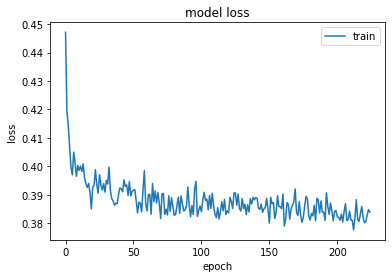

Epoch 1/225
2666/2666 [==============================] - 2s 733us/step - loss: 0.4482 - binary_accuracy: 0.8368
Epoch 2/225
2666/2666 [==============================] - 1s 465us/step - loss: 0.4178 - binary_accuracy: 0.8382
Epoch 3/225
2666/2666 [==============================] - 1s 468us/step - loss: 0.4114 - binary_accuracy: 0.8398
Epoch 4/225
2666/2666 [==============================] - 1s 426us/step - loss: 0.4110 - binary_accuracy: 0.8376
Epoch 5/225
2666/2666 [==============================] - 1s 425us/step - loss: 0.4111 - binary_accuracy: 0.8395
Epoch 6/225
2666/2666 [==============================] - 1s 427us/step - loss: 0.4072 - binary_accuracy: 0.8375
Epoch 7/225
2666/2666 [==============================] - 1s 428us/step - loss: 0.4061 - binary_accuracy: 0.8396
Epoch 8/225
2666/2666 [==============================] - 1s 422us/step - loss: 0.4020 - binary_accuracy: 0.8381
Epoch 9/225
2666/2666 [==============================] - 1s 424us/step - loss: 0.4000 - binary_accuracy:

2666/2666 [==============================] - 1s 419us/step - loss: 0.3882 - binary_accuracy: 0.8413
Epoch 74/225
2666/2666 [==============================] - 1s 420us/step - loss: 0.3860 - binary_accuracy: 0.8436
Epoch 75/225
2666/2666 [==============================] - 1s 414us/step - loss: 0.3894 - binary_accuracy: 0.8416
Epoch 76/225
2666/2666 [==============================] - 1s 433us/step - loss: 0.3865 - binary_accuracy: 0.8447
Epoch 77/225
2666/2666 [==============================] - 1s 428us/step - loss: 0.3884 - binary_accuracy: 0.8466
Epoch 78/225
2666/2666 [==============================] - 1s 411us/step - loss: 0.3931 - binary_accuracy: 0.8407
Epoch 79/225
2666/2666 [==============================] - 1s 424us/step - loss: 0.3842 - binary_accuracy: 0.8485
Epoch 80/225
2666/2666 [==============================] - 1s 451us/step - loss: 0.3903 - binary_accuracy: 0.8432
Epoch 81/225
2666/2666 [==============================] - 1s 427us/step - loss: 0.3869 - binary_accuracy: 0.8

2666/2666 [==============================] - 1s 434us/step - loss: 0.3901 - binary_accuracy: 0.8429
Epoch 146/225
2666/2666 [==============================] - 1s 402us/step - loss: 0.3815 - binary_accuracy: 0.8466
Epoch 147/225
2666/2666 [==============================] - 1s 418us/step - loss: 0.3855 - binary_accuracy: 0.8443
Epoch 148/225
2666/2666 [==============================] - 1s 406us/step - loss: 0.3884 - binary_accuracy: 0.8430
Epoch 149/225
2666/2666 [==============================] - 1s 451us/step - loss: 0.3866 - binary_accuracy: 0.8456
Epoch 150/225
2666/2666 [==============================] - 1s 404us/step - loss: 0.3864 - binary_accuracy: 0.8441
Epoch 151/225
2666/2666 [==============================] - 1s 420us/step - loss: 0.3823 - binary_accuracy: 0.8485
Epoch 152/225
2666/2666 [==============================] - 1s 398us/step - loss: 0.3827 - binary_accuracy: 0.8437
Epoch 153/225
2666/2666 [==============================] - 1s 408us/step - loss: 0.3867 - binary_accur

Epoch 217/225
2666/2666 [==============================] - 1s 416us/step - loss: 0.3842 - binary_accuracy: 0.8456
Epoch 218/225
2666/2666 [==============================] - 1s 408us/step - loss: 0.3747 - binary_accuracy: 0.8490
Epoch 219/225
2666/2666 [==============================] - 1s 417us/step - loss: 0.3842 - binary_accuracy: 0.8465
Epoch 220/225
2666/2666 [==============================] - 1s 428us/step - loss: 0.3862 - binary_accuracy: 0.8420
Epoch 221/225
2666/2666 [==============================] - 1s 434us/step - loss: 0.3810 - binary_accuracy: 0.8465
Epoch 222/225
2666/2666 [==============================] - 1s 421us/step - loss: 0.3807 - binary_accuracy: 0.8484
Epoch 223/225
2666/2666 [==============================] - 1s 407us/step - loss: 0.3857 - binary_accuracy: 0.8459
Epoch 224/225
2666/2666 [==============================] - 1s 420us/step - loss: 0.3783 - binary_accuracy: 0.8468
Epoch 225/225
2666/2666 [==============================] - 1s 404us/step - loss: 0.3844 

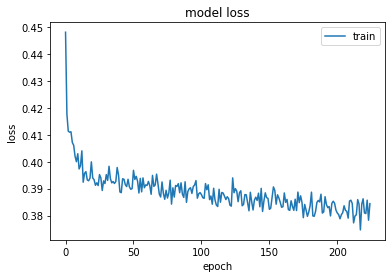

Epoch 1/225
2665/2665 [==============================] - 2s 775us/step - loss: 0.4356 - binary_accuracy: 0.8409
Epoch 2/225
2665/2665 [==============================] - 1s 428us/step - loss: 0.4079 - binary_accuracy: 0.8462
Epoch 3/225
2665/2665 [==============================] - 1s 441us/step - loss: 0.4053 - binary_accuracy: 0.8427
Epoch 4/225
2665/2665 [==============================] - 1s 425us/step - loss: 0.4017 - binary_accuracy: 0.8462
Epoch 5/225
2665/2665 [==============================] - 1s 443us/step - loss: 0.3982 - binary_accuracy: 0.8471
Epoch 6/225
2665/2665 [==============================] - 1s 455us/step - loss: 0.4004 - binary_accuracy: 0.8423
Epoch 7/225
2665/2665 [==============================] - 1s 436us/step - loss: 0.3919 - binary_accuracy: 0.8486
Epoch 8/225
2665/2665 [==============================] - 1s 433us/step - loss: 0.3924 - binary_accuracy: 0.8451
Epoch 9/225
2665/2665 [==============================] - 1s 431us/step - loss: 0.3956 - binary_accuracy:

2665/2665 [==============================] - 1s 409us/step - loss: 0.3811 - binary_accuracy: 0.8492
Epoch 74/225
2665/2665 [==============================] - 1s 406us/step - loss: 0.3821 - binary_accuracy: 0.8513
Epoch 75/225
2665/2665 [==============================] - 1s 412us/step - loss: 0.3867 - binary_accuracy: 0.8466
Epoch 76/225
2665/2665 [==============================] - 1s 407us/step - loss: 0.3857 - binary_accuracy: 0.8487
Epoch 77/225
2665/2665 [==============================] - 1s 404us/step - loss: 0.3817 - binary_accuracy: 0.8472
Epoch 78/225
2665/2665 [==============================] - 1s 408us/step - loss: 0.3831 - binary_accuracy: 0.8494
Epoch 79/225
2665/2665 [==============================] - 1s 410us/step - loss: 0.3835 - binary_accuracy: 0.8473
Epoch 80/225
2665/2665 [==============================] - 1s 411us/step - loss: 0.3854 - binary_accuracy: 0.8478
Epoch 81/225
2665/2665 [==============================] - 1s 420us/step - loss: 0.3796 - binary_accuracy: 0.8

2665/2665 [==============================] - 1s 379us/step - loss: 0.3775 - binary_accuracy: 0.8498
Epoch 146/225
2665/2665 [==============================] - 1s 374us/step - loss: 0.3753 - binary_accuracy: 0.8521
Epoch 147/225
2665/2665 [==============================] - 1s 395us/step - loss: 0.3755 - binary_accuracy: 0.8517
Epoch 148/225
2665/2665 [==============================] - 1s 397us/step - loss: 0.3792 - binary_accuracy: 0.8503
Epoch 149/225
2665/2665 [==============================] - 1s 387us/step - loss: 0.3839 - binary_accuracy: 0.8494
Epoch 150/225
2665/2665 [==============================] - 1s 381us/step - loss: 0.3777 - binary_accuracy: 0.8519
Epoch 151/225
2665/2665 [==============================] - 1s 374us/step - loss: 0.3722 - binary_accuracy: 0.8516
Epoch 152/225
2665/2665 [==============================] - 1s 384us/step - loss: 0.3829 - binary_accuracy: 0.8496
Epoch 153/225
2665/2665 [==============================] - 1s 385us/step - loss: 0.3806 - binary_accur

Epoch 217/225
2665/2665 [==============================] - 1s 376us/step - loss: 0.3751 - binary_accuracy: 0.8512
Epoch 218/225
2665/2665 [==============================] - 1s 376us/step - loss: 0.3790 - binary_accuracy: 0.8497
Epoch 219/225
2665/2665 [==============================] - 1s 376us/step - loss: 0.3765 - binary_accuracy: 0.8497
Epoch 220/225
2665/2665 [==============================] - 1s 380us/step - loss: 0.3761 - binary_accuracy: 0.8541
Epoch 221/225
2665/2665 [==============================] - 1s 376us/step - loss: 0.3776 - binary_accuracy: 0.8486
Epoch 222/225
2665/2665 [==============================] - 1s 381us/step - loss: 0.3768 - binary_accuracy: 0.8492
Epoch 223/225
2665/2665 [==============================] - 1s 378us/step - loss: 0.3771 - binary_accuracy: 0.8507
Epoch 224/225
2665/2665 [==============================] - 1s 391us/step - loss: 0.3764 - binary_accuracy: 0.8491
Epoch 225/225
2665/2665 [==============================] - 1s 411us/step - loss: 0.3735 

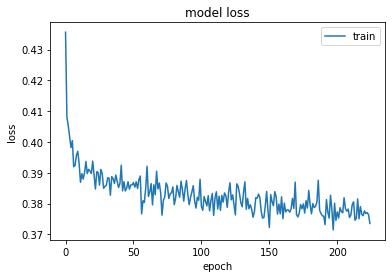

Epoch 1/225
2665/2665 [==============================] - 2s 800us/step - loss: 0.4357 - binary_accuracy: 0.8376
Epoch 2/225
2665/2665 [==============================] - 1s 403us/step - loss: 0.4118 - binary_accuracy: 0.8424
Epoch 3/225
2665/2665 [==============================] - 1s 385us/step - loss: 0.4066 - binary_accuracy: 0.8424
Epoch 4/225
2665/2665 [==============================] - 1s 394us/step - loss: 0.4004 - binary_accuracy: 0.8455
Epoch 5/225
2665/2665 [==============================] - 1s 393us/step - loss: 0.4034 - binary_accuracy: 0.8416
Epoch 6/225
2665/2665 [==============================] - 1s 405us/step - loss: 0.3927 - binary_accuracy: 0.8450
Epoch 7/225
2665/2665 [==============================] - 1s 398us/step - loss: 0.3911 - binary_accuracy: 0.8463
Epoch 8/225
2665/2665 [==============================] - 1s 390us/step - loss: 0.3917 - binary_accuracy: 0.8461
Epoch 9/225
2665/2665 [==============================] - 1s 386us/step - loss: 0.3902 - binary_accuracy:

2665/2665 [==============================] - 1s 380us/step - loss: 0.3863 - binary_accuracy: 0.8473
Epoch 74/225
2665/2665 [==============================] - 1s 375us/step - loss: 0.3848 - binary_accuracy: 0.8498
Epoch 75/225
2665/2665 [==============================] - 1s 385us/step - loss: 0.3792 - binary_accuracy: 0.8469
Epoch 76/225
2665/2665 [==============================] - 1s 382us/step - loss: 0.3827 - binary_accuracy: 0.8498
Epoch 77/225
2665/2665 [==============================] - 1s 377us/step - loss: 0.3787 - binary_accuracy: 0.8470
Epoch 78/225
2665/2665 [==============================] - 1s 379us/step - loss: 0.3855 - binary_accuracy: 0.8453
Epoch 79/225
2665/2665 [==============================] - 1s 375us/step - loss: 0.3838 - binary_accuracy: 0.8441
Epoch 80/225
2665/2665 [==============================] - 1s 383us/step - loss: 0.3785 - binary_accuracy: 0.8497
Epoch 81/225
2665/2665 [==============================] - 1s 373us/step - loss: 0.3829 - binary_accuracy: 0.8

2665/2665 [==============================] - 1s 386us/step - loss: 0.3786 - binary_accuracy: 0.8509
Epoch 146/225
2665/2665 [==============================] - 1s 374us/step - loss: 0.3816 - binary_accuracy: 0.8469
Epoch 147/225
2665/2665 [==============================] - 1s 376us/step - loss: 0.3859 - binary_accuracy: 0.8471
Epoch 148/225
2665/2665 [==============================] - 1s 373us/step - loss: 0.3791 - binary_accuracy: 0.8463
Epoch 149/225
2665/2665 [==============================] - 1s 373us/step - loss: 0.3803 - binary_accuracy: 0.8495
Epoch 150/225
2665/2665 [==============================] - 1s 387us/step - loss: 0.3767 - binary_accuracy: 0.8460
Epoch 151/225
2665/2665 [==============================] - 1s 372us/step - loss: 0.3811 - binary_accuracy: 0.8460
Epoch 152/225
2665/2665 [==============================] - 1s 384us/step - loss: 0.3834 - binary_accuracy: 0.8467
Epoch 153/225
2665/2665 [==============================] - 1s 385us/step - loss: 0.3815 - binary_accur

Epoch 217/225
2665/2665 [==============================] - 1s 377us/step - loss: 0.3755 - binary_accuracy: 0.8511
Epoch 218/225
2665/2665 [==============================] - 1s 380us/step - loss: 0.3804 - binary_accuracy: 0.8476
Epoch 219/225
2665/2665 [==============================] - 1s 376us/step - loss: 0.3728 - binary_accuracy: 0.8515
Epoch 220/225
2665/2665 [==============================] - 1s 377us/step - loss: 0.3792 - binary_accuracy: 0.8479
Epoch 221/225
2665/2665 [==============================] - 1s 376us/step - loss: 0.3818 - binary_accuracy: 0.8460
Epoch 222/225
2665/2665 [==============================] - 1s 384us/step - loss: 0.3746 - binary_accuracy: 0.8519
Epoch 223/225
2665/2665 [==============================] - 1s 374us/step - loss: 0.3723 - binary_accuracy: 0.8525
Epoch 224/225
2665/2665 [==============================] - 1s 372us/step - loss: 0.3816 - binary_accuracy: 0.8457
Epoch 225/225
2665/2665 [==============================] - 1s 378us/step - loss: 0.3781 

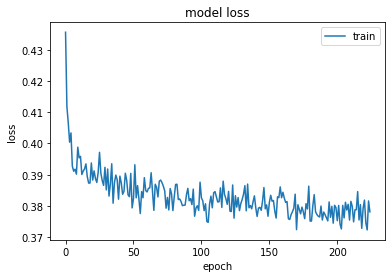

In [57]:
## Run 5-fold cross-validation to get average performance characteristics
unit = 32
ratio = 0.5
epoch = 225
(auroc_list, other_metric_list) = kfold_validation(unit, ratio, epoch, X_train_transformed, y_train, 'patient-id', \
                                                   n_features=n_features, verbose=1)

In [58]:
## other_metric_list has precision, recall, accuracy, specificity, f1, threshold for metrics
ave_prec = np.mean([x[0] for x in other_metric_list])
print("average precision:" + str(ave_prec))

ave_recall = np.mean([x[1] for x in other_metric_list])
print("average recall:" + str(ave_recall))

ave_specificity = np.mean([x[3] for x in other_metric_list])
print("average specificity:" + str(ave_specificity))

ave_f1 = np.mean([x[4] for x in other_metric_list])
print("average F1:" + str(ave_f1))

average precision:0.3537697612378618
average recall:0.5409042335912906
average specificity:0.8092145544260807
average F1:0.4249295073517253


In [59]:
max_f1 = np.max([x[4] for x in other_metric_list])
print("max F1: " + str(max_f1))

max F1: 0.45123726346433773


In [60]:
## Average metrics performance
print("unit: %d\tepoch: %d\tauroc_mean: %f\tauroc_std: %f"  % (unit, epoch, np.mean(auroc_list), np.std(auroc_list)))

unit: 32	epoch: 225	auroc_mean: 0.742040	auroc_std: 0.008418


In [ ]:
#y_predict = model.predict(X_test_pad)
#y_test_len = [len(y) for y in y_test_list]
#y_predict = truncate_prediction(y_predict, y_test_len)
#y_true = np.concatenate(y_test_list)

In [138]:
y_true[0:100]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [62]:
y_true

array([0, 0, 0, ..., 0, 0, 0])

In [64]:
X_test_use['patient-id'].values

array(['10385', '10386', '5030', ..., 'feae250c18c35ee64e91e6731e401ff6',
       'feae250c18c35ee64e91e6731e401ff6',
       'ff6e92ac2e24c4c454921ba6ced5ecfa'], dtype=object)

In [167]:
y_test_list

[array([0]),
 array([0]),
 array([0, 0, 0]),
 array([0, 1, 1, 1, 0]),
 array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]),
 array([0, 0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0, 0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 array([1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]),
 array([0, 0, 0, 1, 0]),
 array([0]),
 array([0]),
 array([0]),
 array([0, 0, 1, 0]),
 array([0]),
 array([0]),
 array([0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 0]),
 array([0, 0]),
 array([0]),
 array([0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]),
 array([0]),
 array([0]),
 array([0]),
 array([0, 0, 0]),
 array([0]),
 array([0, 0]),
 array([0]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 array([0]),
 array([0]),
 array([1, 0, 1, 0, 0, 0, 0]),
 array([0]),
 array([0, 0, 0]),
 array([0, 0]),
 array([0]),
 array([0]),
 array([0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0]),
 array([0]),
 array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 

In [152]:
pid_list=(X_test_transformed['patient-id'].values).tolist()

In [120]:
prediction = model.predict(X_test_pad)

In [121]:
pred_list=prediction.tolist()

In [161]:
true_list=y_test.to_list()

In [162]:
len(pid_list)

3692

In [163]:
len(pred_list)

1429

In [164]:
len(true_list)

3692

In [157]:
#pid_loc_pred = pd.DataFrame(np.column_stack([pid_list, pred_list, true_list]), 
 #                              columns=['patient-id', 'RNN', 'true outcome'])

In [150]:
#pid_loc_pred['compare'] = pid_loc_pred['RNN'] == pid_loc_pred['true outcome']

In [147]:
#pid_loc_pred.loc[pid_loc_pred['compare']]

In [151]:
#pid_loc_pred